In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torch torchvision

In [3]:
import sys
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

# Analysis

In [4]:
data_dirname = '../input/sports-classification'
print(os.listdir(data_dirname))

['EfficientNetB0-100-(224 X 224)- 98.40.h5', 'sports.csv', 'valid', 'test', 'train']


In [5]:
# 100 Sports
classes = os.listdir(data_dirname + '/train')
print("Number of sports:", len(classes))
print("\nList of sports:\n", classes)

Number of sports: 100

List of sports:
 ['bobsled', 'hurdles', 'snow boarding', 'fly fishing', 'luge', 'sidecar racing', 'ampute football', 'volleyball', 'billiards', 'giant slalom', 'tennis', 'horse racing', 'pole dancing', 'figure skating women', 'rollerblade racing', 'fencing', 'olympic wrestling', 'golf', 'ultimate', 'harness racing', 'football', 'frisbee', 'bungee jumping', 'shot put', 'ice climbing', 'figure skating men', 'rowing', 'bike polo', 'swimming', 'judo', 'axe throwing', 'archery', 'baseball', 'wheelchair basketball', 'log rolling', 'lacrosse', 'rock climbing', 'horse jumping', 'hydroplane racing', 'formula 1 racing', 'curling', 'jousting', 'javelin', 'water cycling', 'speed skating', 'barell racing', 'bull riding', 'horseshoe pitching', 'croquet', 'chuckwagon racing', 'hammer throw', 'rugby', 'pole climbing', 'nascar racing', 'snowmobile racing', 'boxing', 'mushing', 'track bicycle', 'canoe slamon', 'disc golf', 'bmx', 'air hockey', 'rings', 'trapeze', 'motorcycle racin

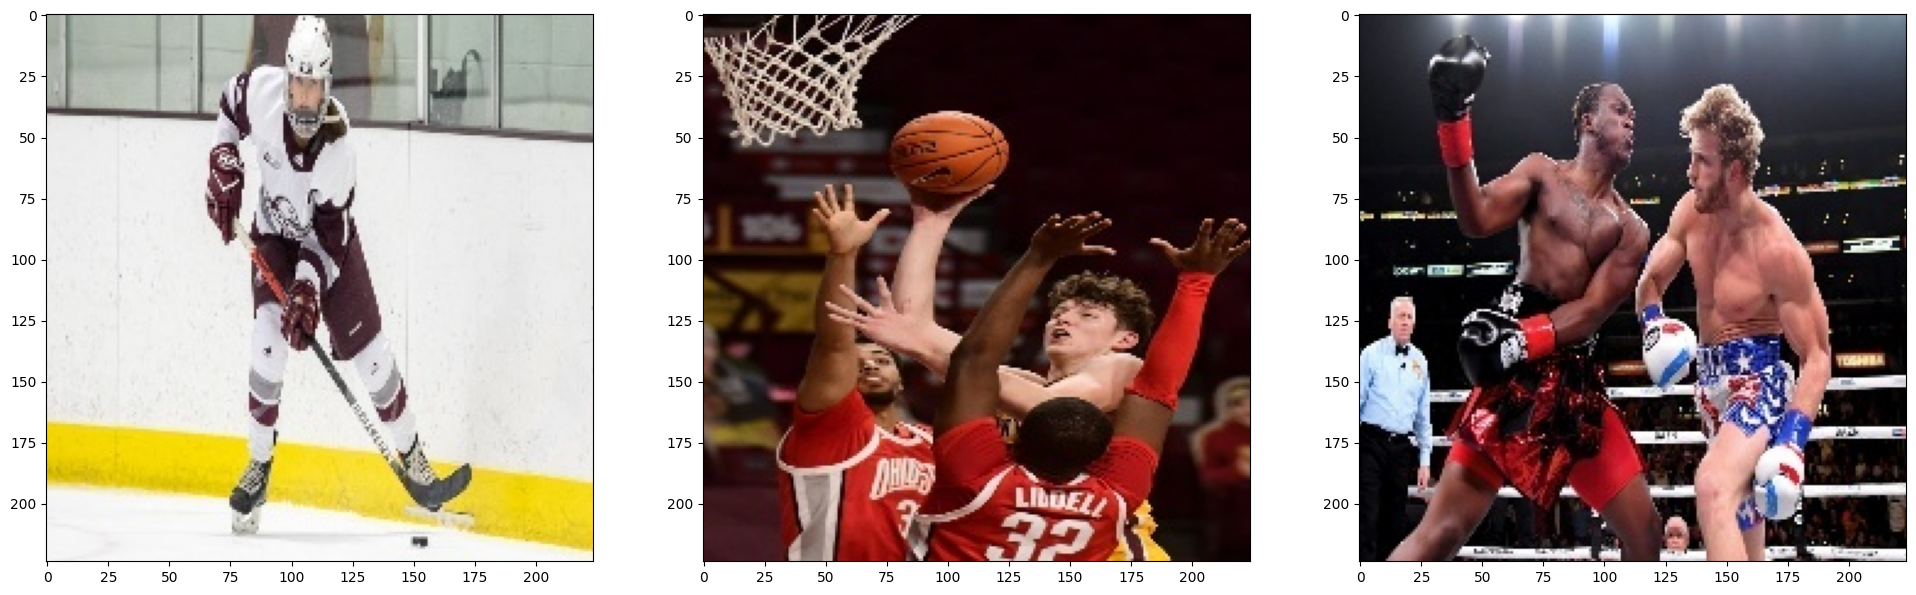

In [6]:
# images visualisation
image_path = []
num = 3
image_path.append(data_dirname + '/train/hockey/001.jpg')
image_path.append(data_dirname + '/train/basketball/011.jpg')
image_path.append(data_dirname + '/train/boxing/015.jpg')
images = [cv2.imread(image_path[i]) for i in range(num)]
rgb_images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images]

fig, ax = plt.subplots(1, 3, figsize = (24, 24))
for i, img in enumerate(rgb_images): 
    ax[i].imshow(img)

In [7]:
df = pd.read_csv(data_dirname + '/sports.csv')
df

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train
...,...,...,...,...
14488,99,valid/wingsuit flying/1.jpg,wingsuit flying,valid
14489,99,valid/wingsuit flying/2.jpg,wingsuit flying,valid
14490,99,valid/wingsuit flying/3.jpg,wingsuit flying,valid
14491,99,valid/wingsuit flying/4.jpg,wingsuit flying,valid


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14493 entries, 0 to 14492
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class id   14493 non-null  int64 
 1   filepaths  14493 non-null  object
 2   labels     14493 non-null  object
 3   data set   14493 non-null  object
dtypes: int64(1), object(3)
memory usage: 453.0+ KB


In [9]:
train_df = df.loc[df['data set'] == 'train']
train_df.head()

,class id,filepaths,labels,data set
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train


In [10]:
valid_df = df.loc[df['data set'] == 'valid']
valid_df.head()

,class id,filepaths,labels,data set
13993,0,valid/air hockey/1.jpg,air hockey,valid
13994,0,valid/air hockey/2.jpg,air hockey,valid
13995,0,valid/air hockey/3.jpg,air hockey,valid
13996,0,valid/air hockey/4.jpg,air hockey,valid
13997,0,valid/air hockey/5.jpg,air hockey,valid


In [11]:
test_df = df.loc[df['data set'] == 'test']
test_df.head()

,class id,filepaths,labels,data set
13493,0,test/air hockey/1.jpg,air hockey,test
13494,0,test/air hockey/2.jpg,air hockey,test
13495,0,test/air hockey/3.jpg,air hockey,test
13496,0,test/air hockey/4.jpg,air hockey,test
13497,0,test/air hockey/5.jpg,air hockey,test


<Axes: ylabel='labels'>

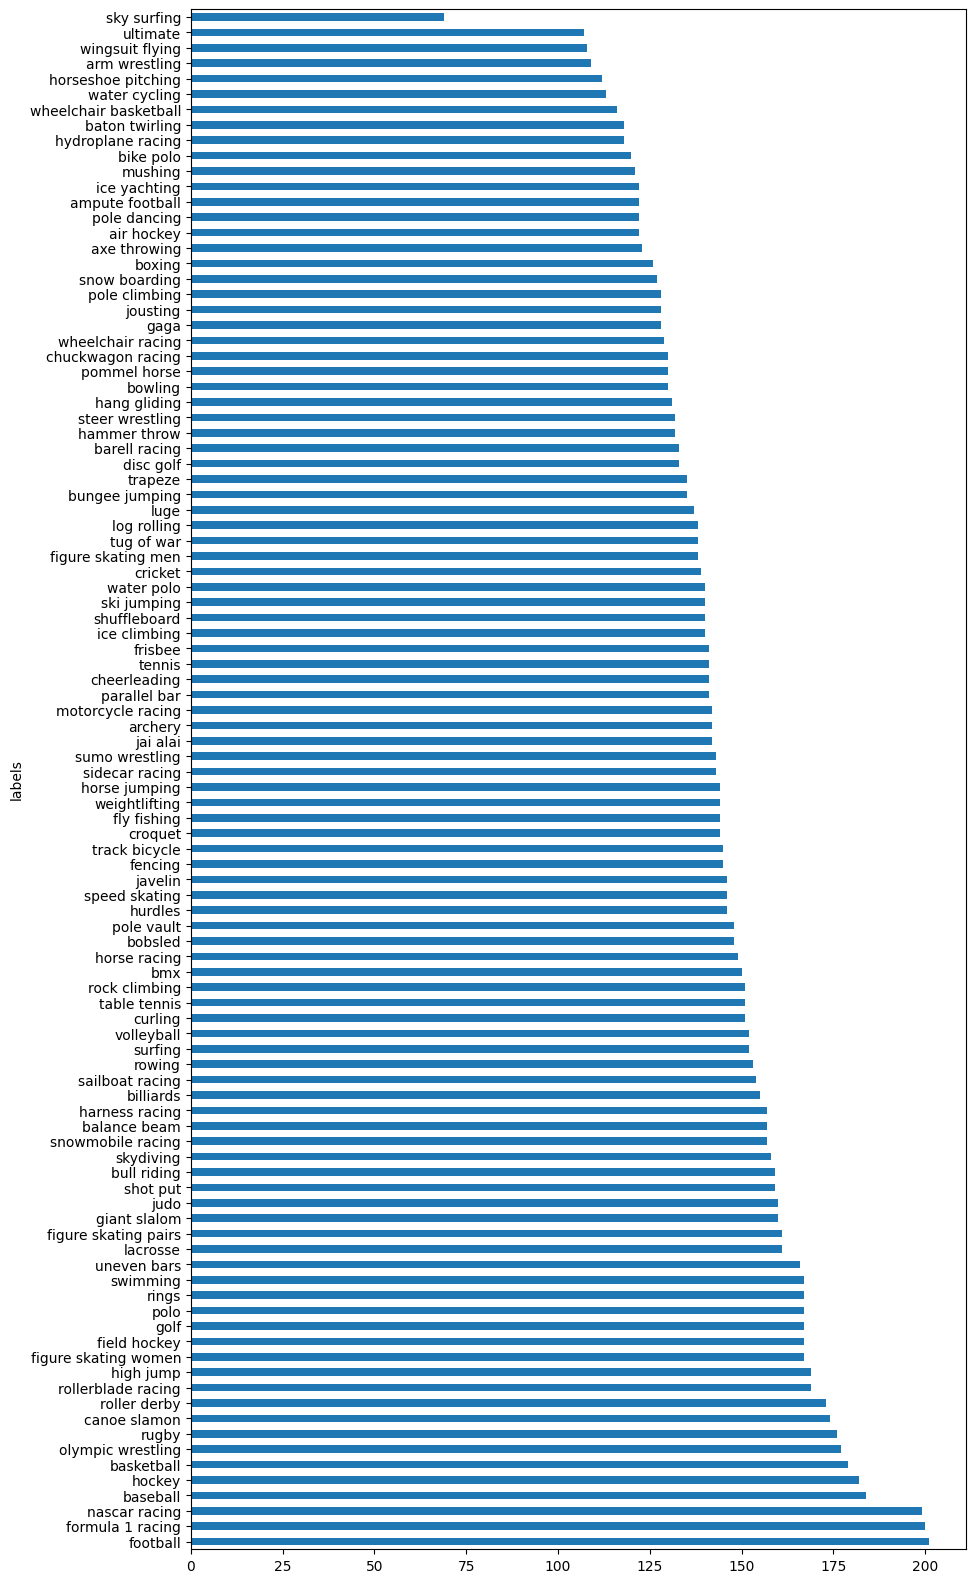

In [12]:
# distribution of classes
df.value_counts('labels').plot.barh(figsize=(10, 20))

# Load data

In [13]:
input_shape = (224, 224)
num_labels = 100
workers = os.cpu_count()
batch_size = 64

In [14]:
# augmentations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-15, 15)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

In [15]:
# training, validation and test datasets
train_dataset = ImageFolder(root=data_dirname + '/train', transform=train_transform)
valid_dataset = ImageFolder(root=data_dirname + '/valid', transform=valid_transform)
test_dataset = ImageFolder(root=data_dirname + '/test', transform=valid_transform)
print(train_dataset)
print(valid_dataset)
print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 13492
    Root location: ../input/sports-classification/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Dataset ImageFolder
    Number of datapoints: 500
    Root location: ../input/sports-classification/valid
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
Dataset ImageFolder
    Number of datapoints: 500
    Root location: ../input/sports-classification/test
    StandardT

In [16]:
# check classes 
print(len(train_dataset.classes), '\n', train_dataset.classes)

100 
 ['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling', 'bike polo', 'billiards', 'bmx', 'bobsled', 'bowling', 'boxing', 'bull riding', 'bungee jumping', 'canoe slamon', 'cheerleading', 'chuckwagon racing', 'cricket', 'croquet', 'curling', 'disc golf', 'fencing', 'field hockey', 'figure skating men', 'figure skating pairs', 'figure skating women', 'fly fishing', 'football', 'formula 1 racing', 'frisbee', 'gaga', 'giant slalom', 'golf', 'hammer throw', 'hang gliding', 'harness racing', 'high jump', 'hockey', 'horse jumping', 'horse racing', 'horseshoe pitching', 'hurdles', 'hydroplane racing', 'ice climbing', 'ice yachting', 'jai alai', 'javelin', 'jousting', 'judo', 'lacrosse', 'log rolling', 'luge', 'motorcycle racing', 'mushing', 'nascar racing', 'olympic wrestling', 'parallel bar', 'pole climbing', 'pole dancing', 'pole vault', 'polo', 'pommel horse', 'rings', 'rock climbing', 'r

In [17]:
# training, validation and test loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=workers,
    shuffle=True,
    drop_last=True,
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    num_workers=workers,
    shuffle=False,
    drop_last=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=workers,
    shuffle=False,
    drop_last=False,
)

# The Training and Validation Functions

In [18]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
    """
    Training function
    """

    model.train()

    losses = []
    accuracies = []

    with tqdm(total=len(loader), desc="training", file=sys.stdout, ncols=100, disable=not verbose) as progress:
        for x_batch, y_true in loader:
            x_batch = x_batch.to(device)
            y_true = y_true.to(device)

            optimizer.zero_grad()
            # forward pass
            y_pred = model(x_batch)
            # calculate the loss
            loss = criterion(y_pred, y_true)
            # backpropagation
            loss.backward()

            losses.append(loss.item())
            accuracies.append((y_pred.argmax(1) == y_true).float().detach().cpu().numpy())

            progress.set_postfix_str(f"loss {losses[-1]:.4f}")

            # update the optimizer parameters
            optimizer.step()

            progress.update(1)

    logs = {
        "losses": np.array(losses),
        "accuracies": np.concatenate(accuracies)
    }

    return logs

In [19]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
    """
    Validation function
    """

    model.eval()

    losses = []
    accuracies = []

    for x_batch, y_true in tqdm(loader, desc="evaluation", file=sys.stdout, ncols=100, disable=not verbose):
        x_batch = x_batch.to(device)
        y_true = y_true.to(device)

        # forward pass
        y_pred = model(x_batch)
        # calculate the loss
        loss = criterion(y_pred, y_true)

        losses.append(loss.item())
        accuracies.append((y_pred.argmax(1) == y_true).float().detach().cpu().numpy())

    logs = {
        "losses": np.array(losses),
        "accuracies": np.concatenate(accuracies)
    }

    return logs

In [20]:
def save_model(file_name, epoch, n_epochs, model, optimizer, train_loss, train_accuracy, valid_loss, valid_accuracy):
    """
    Function to save the trained model to disk.
    """
    checkpoint = {
                 "model_state_dict": model.state_dict(),
                 "optimizer_state_dict": optimizer.state_dict(),
                 "epoch": epoch,
                 "num_epochs": n_epochs,
                 "metrics": {
                    "training": {"loss": train_loss, "accuracy": train_accuracy},
                    "validation": {"loss": valid_loss, "accuracy": valid_accuracy},
                 },
    }
    torch.save(checkpoint, f'/kaggle/working/{file_name}')

# The Training Loop

In [21]:
# this function will be used for the competitions of different models
def models_competition(model_name: str, model, train_loader, valid_loader, loss_fn, optimizer, device):
    """
    Function that should be used for the competitions of different models
    """
    n_epochs = 20

    # lists to keep track of losses and accuracies
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    
    best_score = float("-inf")

    for ep in range(n_epochs):
        print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

        train_logs = train_one_epoch(model, train_loader, loss_fn, optimizer, device, verbose=True)
        train_losses.append(np.mean(train_logs["losses"]))
        train_accuracies.append(np.mean(train_logs["accuracies"]))
        print("      loss:", train_losses[-1])
        print("  accuracy:", train_accuracies[-1])


        valid_logs = evaluate(model, valid_loader, loss_fn, device, verbose=True)
        valid_losses.append(np.mean(valid_logs["losses"]))
        valid_accuracies.append(np.mean(valid_logs["accuracies"]))
        print("      loss:", valid_losses[-1])
        print("  accuracy:", valid_accuracies[-1])
        
        scheduler.step(valid_losses[-1])
        
        # save the trained model weights
        file_name = f'best_{model_name}.pth'
        if valid_accuracies[-1] >= best_score:
            save_model(file_name, ep + 1, n_epochs, model, optimizer, train_losses[-1], train_accuracies[-1], valid_losses[-1], valid_accuracies[-1])
            best_score = valid_accuracies[-1]

    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [22]:
def visualize_results(train_losses, train_accuracies, valid_losses, valid_accuracies):
    """
    Function to plot the losses and accuracies
    """
    
    fix, axes = plt.subplots(ncols=2, figsize=(15, 4))

    axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
    axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
    axes[0].legend(["train", "validation"])
    axes[0].set_title("Loss")
    axes[0].grid()

    axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")
    axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")
    axes[1].legend(["train", "validation"])
    axes[1].set_title("Accuracy")
    axes[1].grid();

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}\n")

Device - cuda



# Modeling

## ResNet18

In [24]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
torch.manual_seed(42)
model.fc = nn.Linear(model.fc.in_features, num_labels)
model = model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)

train_losses, train_accuracies, valid_losses, valid_accuracies = models_competition('resnet18', model, train_loader, valid_loader, loss_fn, optimizer, device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 199MB/s]


Number of trainable parameters - 11227812

Epoch  1/20
training: 100%|██████████████████████████████████████| 210/210 [00:41<00:00,  5.10it/s, loss 1.7036]
      loss: 2.6437595134689693
  accuracy: 0.46309525
evaluation: 100%|█████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.43it/s]
      loss: 1.1835804656147957
  accuracy: 0.782

Epoch  2/20
training: 100%|██████████████████████████████████████| 210/210 [00:39<00:00,  5.27it/s, loss 0.8169]
      loss: 1.0702138015202114
  accuracy: 0.7923363
evaluation: 100%|█████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.94it/s]
      loss: 0.629873014986515
  accuracy: 0.878

Epoch  3/20
training: 100%|██████████████████████████████████████| 210/210 [00:40<00:00,  5.18it/s, loss 0.7199]
      loss: 0.6436171748808452
  accuracy: 0.86651784
evaluation: 100%|█████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.79it/s]
      loss: 0.45007218047976494
  accuracy: 0.888

Epoc

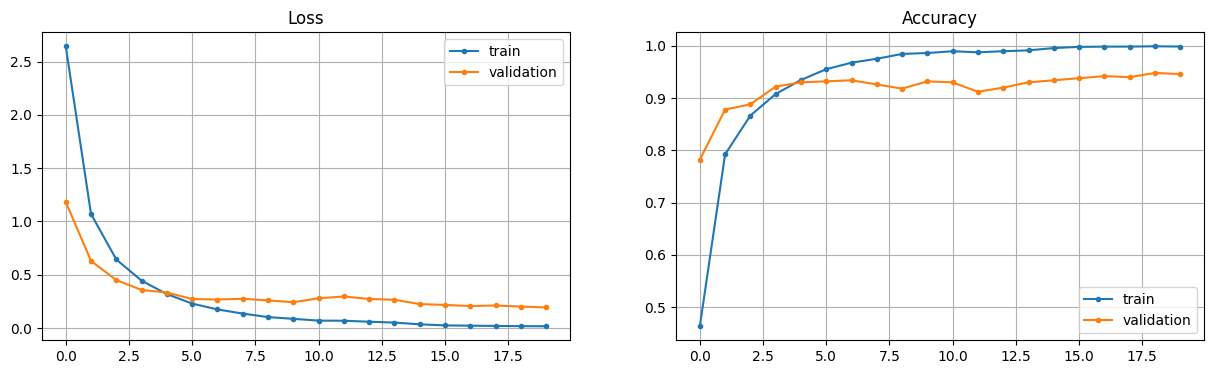

In [25]:
visualize_results(train_losses, train_accuracies, valid_losses, valid_accuracies)

In [26]:
best_state = torch.load('/kaggle/working/best_resnet18.pth')
print(best_state['epoch'])
print(best_state['metrics'])

19
{'training': {'loss': 0.01798656986405452, 'accuracy': 0.9991071}, 'validation': {'loss': 0.20190886687487364, 'accuracy': 0.948}}


## MobileNet_V3_Large

In [27]:
model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
torch.manual_seed(42)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_labels, bias=True)
model = model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)

train_losses, train_accuracies, valid_losses, valid_accuracies = models_competition('mobilenet', model, train_loader, valid_loader, loss_fn, optimizer, device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 146MB/s] 


Number of trainable parameters - 4330132

Epoch  1/20
training: 100%|██████████████████████████████████████| 210/210 [00:41<00:00,  5.12it/s, loss 1.3820]
      loss: 2.883691146260216
  accuracy: 0.39136904
evaluation: 100%|█████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.36it/s]
      loss: 0.9967659711837769
  accuracy: 0.716

Epoch  2/20
training: 100%|██████████████████████████████████████| 210/210 [00:40<00:00,  5.16it/s, loss 0.5385]
      loss: 0.8090811963592257
  accuracy: 0.79129463
evaluation: 100%|█████████████████████████████████████████████████████| 8/8 [00:00<00:00,  9.09it/s]
      loss: 0.43297307565808296
  accuracy: 0.888

Epoch  3/20
training: 100%|██████████████████████████████████████| 210/210 [00:40<00:00,  5.15it/s, loss 0.3547]
      loss: 0.4481267639568874
  accuracy: 0.87879467
evaluation: 100%|█████████████████████████████████████████████████████| 8/8 [00:00<00:00,  8.63it/s]
      loss: 0.2839292995631695
  accuracy: 0.926

Epoc

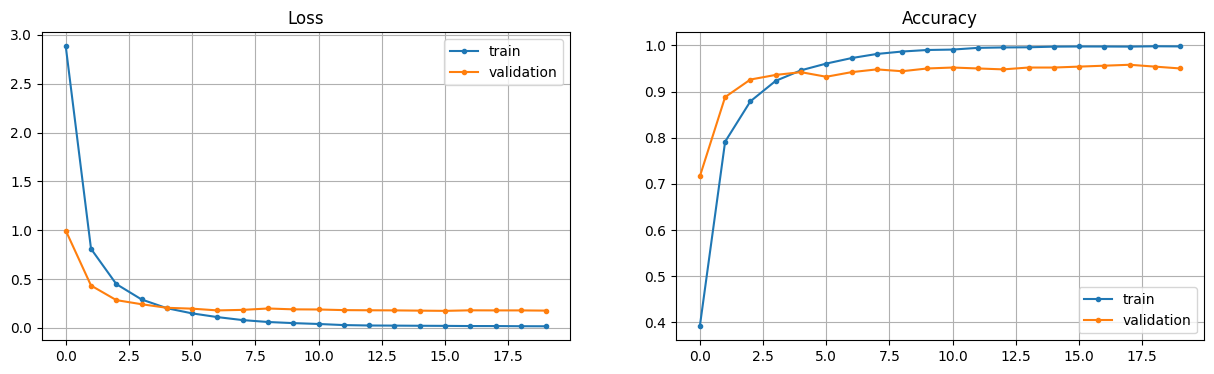

In [28]:
visualize_results(train_losses, train_accuracies, valid_losses, valid_accuracies)

In [29]:
best_state = torch.load('/kaggle/working/best_mobilenet.pth')
print(best_state['epoch'])
print(best_state['metrics'])

18
{'training': {'loss': 0.01807952393622448, 'accuracy': 0.9973214}, 'validation': {'loss': 0.1784291648073122, 'accuracy': 0.958}}


## VGG11

In [30]:
model = models.vgg11(weights=models.VGG11_Weights.IMAGENET1K_V1)
torch.manual_seed(42)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_labels, bias=True)
model = model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)

train_losses, train_accuracies, valid_losses, valid_accuracies = models_competition('vgg11', model, train_loader, valid_loader, loss_fn, optimizer, device)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:02<00:00, 242MB/s]


Number of trainable parameters - 129176036

Epoch  1/20
training: 100%|██████████████████████████████████████| 210/210 [01:40<00:00,  2.08it/s, loss 1.5216]
      loss: 2.5702709175291516
  accuracy: 0.35543156
evaluation: 100%|█████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.67it/s]
      loss: 0.9176123961806297
  accuracy: 0.728

Epoch  2/20
training: 100%|██████████████████████████████████████| 210/210 [01:49<00:00,  1.91it/s, loss 1.6770]
      loss: 1.0773980696996053
  accuracy: 0.68973213
evaluation: 100%|█████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.76it/s]
      loss: 0.586611982434988
  accuracy: 0.828

Epoch  3/20
training: 100%|██████████████████████████████████████| 210/210 [01:40<00:00,  2.09it/s, loss 0.7911]
      loss: 0.7263309884639013
  accuracy: 0.7870536
evaluation: 100%|█████████████████████████████████████████████████████| 8/8 [00:01<00:00,  4.65it/s]
      loss: 0.4964553155004978
  accuracy: 0.858

Epoc

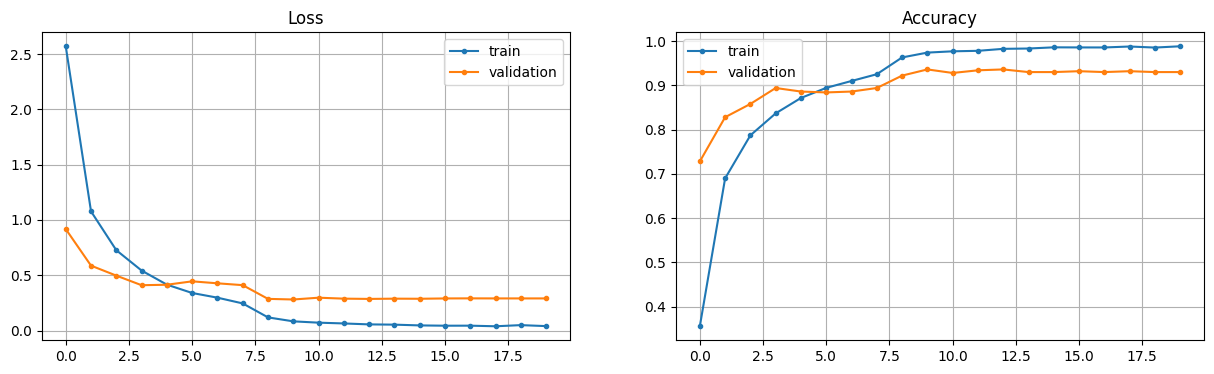

In [31]:
visualize_results(train_losses, train_accuracies, valid_losses, valid_accuracies)

In [32]:
best_state = torch.load('/kaggle/working/best_vgg11.pth')
print(best_state['epoch'])
print(best_state['metrics'])

13
{'training': {'loss': 0.055364523049710054, 'accuracy': 0.98251486}, 'validation': {'loss': 0.28572854958474636, 'accuracy': 0.936}}


## EfficientNet_B1

In [33]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V2)
torch.manual_seed(42)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_labels, bias=True)
model = model.to(device)
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

optimizer = optim.Adam(model.parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3, verbose=True)

train_losses, train_accuracies, valid_losses, valid_accuracies = models_competition('efficientnet', model, train_loader, valid_loader, loss_fn, optimizer, device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 180MB/s]


Number of trainable parameters - 6641284

Epoch  1/20
training: 100%|██████████████████████████████████████| 210/210 [01:33<00:00,  2.24it/s, loss 2.1278]
      loss: 3.5799940137636095
  accuracy: 0.30714285
evaluation: 100%|█████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.61it/s]
      loss: 1.7933757901191711
  accuracy: 0.694

Epoch  2/20
training: 100%|██████████████████████████████████████| 210/210 [01:33<00:00,  2.24it/s, loss 0.9791]
      loss: 1.3379766285419463
  accuracy: 0.71912205
evaluation: 100%|█████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.70it/s]
      loss: 0.6659193783998489
  accuracy: 0.888

Epoch  3/20
training: 100%|██████████████████████████████████████| 210/210 [01:33<00:00,  2.24it/s, loss 0.4461]
      loss: 0.7252128196614129
  accuracy: 0.8359375
evaluation: 100%|█████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.46it/s]
      loss: 0.3697282522916794
  accuracy: 0.93

Epoch 

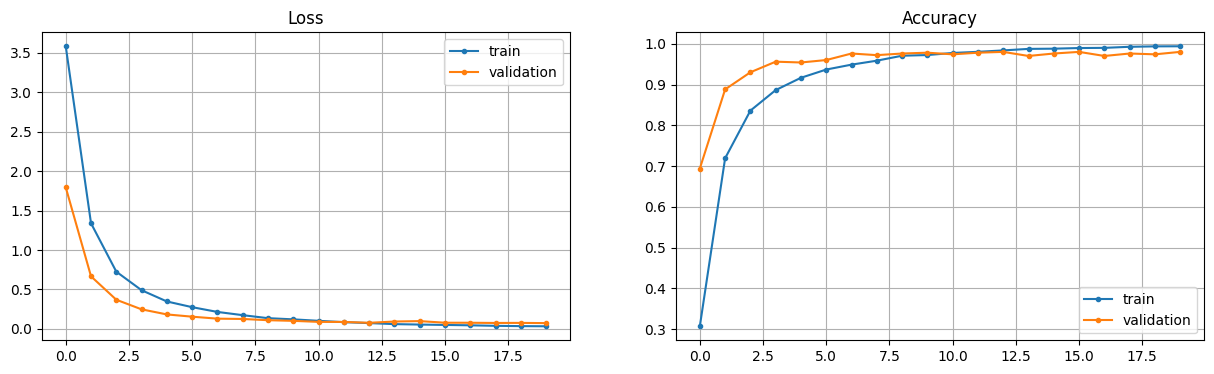

In [34]:
visualize_results(train_losses, train_accuracies, valid_losses, valid_accuracies)

In [35]:
best_state = torch.load('/kaggle/working/best_efficientnet.pth')
print(best_state['epoch'])
print(best_state['metrics'])

20
{'training': {'loss': 0.033623266450705985, 'accuracy': 0.99375}, 'validation': {'loss': 0.07364031940232962, 'accuracy': 0.98}}


## Conclusions
### In the competition of 4 models (ResNet18, MobileNet_V3_Large, VGG11 and EfficientNet_B1) on this dataset, as could be expected, EfficientNet demonstrated  best results.  So, EfficientNet_B1 in its best state should be used for test dataset and for prediction of the labels of single images.

# Test

In [36]:
model = models.efficientnet_b1()
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_labels, bias=True)
model = model.to(device)
best_model = torch.load('/kaggle/working/best_efficientnet.pth')
model.load_state_dict(best_model['model_state_dict'])
loss_fn = nn.CrossEntropyLoss()

test_logs = evaluate(model, test_loader, loss_fn, device, verbose=True)
test_loss = np.mean(test_logs["losses"])
test_accuracy = np.mean(test_logs["accuracies"])
print("loss: ", test_loss)
print("accuracy: ", test_accuracy)

evaluation: 100%|█████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.75it/s]
loss:  0.07231911277631298
accuracy:  0.97


Not bad ) I like this model!

# Predicting the labels of single images

In [37]:
def get_test_image(category: str, number: int):
    """
    Get a image from the test dataset by kind of sport (name of folder) and image number 
    """
    image_path = data_dirname + f'/test/{category}/{number}.jpg'
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [38]:
def get_class_name(class_id):
    """
    Get class name by class id
    """
    return df.loc[df["class id"] == class_id].iloc[0]["labels"]

In [39]:
# define preprocess transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])  

In [40]:
def single_image_predict(model, image, loss_fn, device):
    """
    Function to predict the label of a single image
    """
    
    model.eval()
    image = transform(image)
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        outputs = model(image.to(device))
    output_label = torch.topk(outputs, 1)
    pred_class_id = int(output_label.indices)
    pred_class_name = get_class_name(pred_class_id)
    
    return  pred_class_name

In [41]:
model = models.efficientnet_b1()
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_labels, bias=True)
model = model.to(device)
best_model = torch.load('/kaggle/working/best_efficientnet.pth')
model.load_state_dict(best_model['model_state_dict'])
loss_fn = nn.CrossEntropyLoss()

Predicted label:  basketball


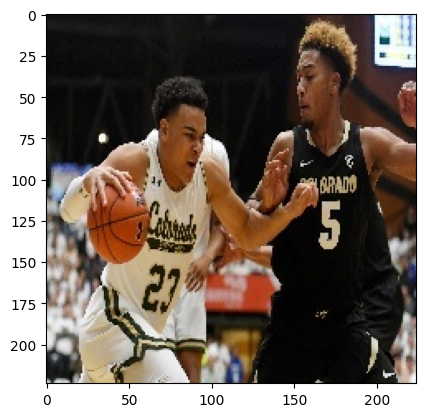

In [42]:
image = get_test_image('basketball', 5)
plt.imshow(image)
pred_label = single_image_predict(model, image, loss_fn, device)
print("Predicted label: ", pred_label)

Predicted label:  boxing


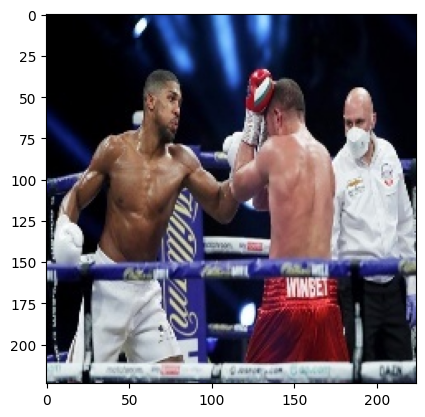

In [43]:
image = get_test_image('boxing', 3)
plt.imshow(image)
pred_label = single_image_predict(model, image, loss_fn, device)
print("Predicted label: ", pred_label)

Predicted label:  hockey


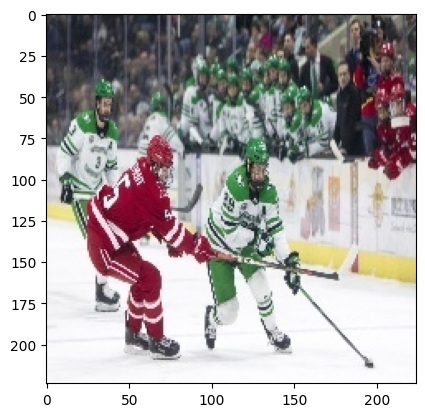

In [44]:
image = get_test_image('hockey', 1)
plt.imshow(image)
pred_label = single_image_predict(model, image, loss_fn, device)
print("Predicted label: ", pred_label)